### TMS Part 2 development
Goal: Walk through all steps to pivot date and then continue day by day trading

#### Pseudocode initialize and In Sample


5.	Update system dict
6.	Define features in feature dict
7.	Load data
8.	Apply features
9.	Save data 
10.	Examine correlation of features
  1. Correlation chart
  2. Identify highly correlated features
  3. Mark those features to Drop
11.	Examine feature importance of remaining features
  1. Utilize various methods to examine
  2. Mark least important features to Drop
12.	[When to examine stationarity]
13.	Save feature dict
14.	Load system dict <to add>
15.	Define time series split parameters
16.	Add to system dict
17.	Classification
  1. Define classification model, parameters
  2. Add to system dict
  3. Set IS start-end dates
  4. IS analysis (start…end)
    1. Drop cols
    2. Prep data
    3. Split data
    4. Log reg classification <to add>
        1. Perform classification
        2. Acquire classification results
        3. Store results
    5. Designated classification
        1. Perform classification
        2. Acquire classification results
        3. Store results
    6. Increment IS date period
        1. Display results
        2. Save IS model results
        3. Save classification model
        4. Examine results
18.	Go to Out of Sample (if results are promising)


##### Import standard libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
from pandas.tseries.offsets import BDay
import os
import os.path
import pickle
import random
import json

from sklearn.model_selection import StratifiedShuffleSplit, TimeSeriesSplit
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

##### Import custom libraries

In [34]:
from Code.lib.plot_utils import PlotUtility
from Code.lib.time_utils import TimeUtility
from Code.lib.retrieve_data import DataRetrieve, ComputeTarget
from Code.lib.candle_indicators import CandleIndicators
from Code.lib.transformers import Transformers
from Code.lib.ta_momentum_studies import TALibMomentumStudies
from Code.lib.model_utils import ModelUtility, TimeSeriesSplitImproved
from Code.lib.feature_generator import FeatureGenerator
from Code.utilities.stat_tests import stationarity_tests
from Code.lib.config import current_feature, feature_dict
from Code.models import models_utils
from Code.lib.model_algos import AlgoUtility

plotIt = PlotUtility()
timeUtil = TimeUtility()
ct = ComputeTarget()
candle_ind = CandleIndicators()
dSet = DataRetrieve()
taLibMomSt = TALibMomentumStudies()
transf = Transformers()
modelUtil = ModelUtility()
featureGen = FeatureGenerator()
dSet = DataRetrieve()
modelAlgo = AlgoUtility()

In [3]:
# Function to generate system number
def get_sys_number():
    # Generate four digit random number
    a = random.sample(range(10),3)
    number = int(str(random.randint(1,9)) + str(a[0]) + str(a[1]) + str(a[2]))
    return number

In [4]:
# function to create system directory based on system name if one doesn't already exist
def get_system_dir(system_name):
    # Create system directory in current path
    current_directory = os.getcwd()
    system_directory = os.path.join(current_directory, system_name)
    if not os.path.exists(system_directory):
       os.makedirs(system_directory)
    return system_directory

In [5]:
# functions for save and load json files
def save_json(filename, json_file):
    # Save system_dict to file
    #filename = 'system_dict.json'
    file_path = os.path.join(system_directory, filename)
    with open(file_path, 'w') as fp:
        json.dump(json_file, fp, sort_keys=True, indent=4)
        
def load_json(file_path):
    with open(file_path, 'r') as fp:
        json_file = json.load(fp)
    return json_file

#### Establish and save system metadata
If new issue  
    Create system name  
    Create system dict  
Define IS-OOS, pivot date parameters  

Alternative  
Identify system name if existing
Otherwise, if system name is blank, it will create new system
Read system dict..it will contain entries if previous system exists

In [6]:
# set to existing system name OR set to blank if creating new
system_name = ""

# if new system, system name will be created as well as system_dict and directory for files
# if existing, it will read system_dict from local file and display system attributes
if system_name == "":
    issue = "TLT"
    direction = "Long"
    ver_num = 1
    
    # Set IS-OOS parameters
    pivotDate = datetime.date(2018, 4, 2)
    is_oos_ratio = 3
    oos_months = 4
    segments = 2
    
    sys_no = get_sys_number()
    # system name - <issue>-<direction>-system-<####>-V<#>
    system_name = issue + "-" + direction + "-system-" + str(sys_no) + "-V" + str(ver_num)
    print(system_name)
    system_directory = get_system_dir(system_name)
    
    # Create system_dict
    system_dict = {}
    system_dict = {'issue': issue,
                   'direction': direction,
                   'system_name': system_name,
                   'ver_num': ver_num,
                   'pivot_date': pivotDate,
                   'is_oos_ratio': is_oos_ratio,
                   'oos_months': oos_months,
                   'segments': segments}
    save_json('system_dict.json', system_dict)
else:
    current_directory = os.getcwd()
    system_directory = os.path.join(current_directory, system_name)
    if not os.path.exists(system_directory):
        print("system doesn't exist")
    else:
        filename = 'system_dict.json'    
        file_path = os.path.join(system_directory, filename)
        system_dict = load_json(file_path)
        issue = system_dict["issue"]
        direction = system_dict["direction"]
        ver_num = system_dict["ver_num"]
        # Perhaps only load these when needed?
        pivotDate = system_dict["pivotDate"]
        is_oos_ratio = system_dict["is_oos_ratio"]
        oos_months = system_dict["oos_months"]
        segments = system_dict["segments"]
        

TLT-Long-system-7973-V1


### At some point, need to address time parameters
Load from system dict or declare
Am I re-calculating params from function call or saving/retrieving from system dict?

In [7]:
# Set IS-OOS parameters
pivotDate = datetime.date(2018, 4, 2)
is_oos_ratio = 3
oos_months = 4
segments = 2

In [8]:
dataSet = dSet.read_issue_data(issue)

Successfully retrieved data series for TLT


In [13]:
print(dataSet.index[0])

2014-09-26 00:00:00


In [15]:
# get first data from loaded data instead of hard coding start date
dataSet = dSet.set_date_range(dataSet, dataSet.index[0], pivotDate)

#set beLong level
beLongThreshold = 0.000
dataSet = ct.setTarget(dataSet, "Long", beLongThreshold)

In [17]:
# Quick review of loaded data
dataSet

,Symbol,Date,Close,High,Low,Open,Volume,gainAhead,beLong
2014-09-26,TLT,2014-09-26,116.00,116.2850,115.6200,116.02,7800462,0.008017,1
2014-09-29,TLT,2014-09-29,116.93,117.1650,116.6600,117.00,6791793,-0.005644,-1
2014-09-30,TLT,2014-09-30,116.27,117.0400,116.1300,116.66,7277543,0.016857,1
2014-10-01,TLT,2014-10-01,118.23,118.2600,116.8300,116.89,17194898,-0.008712,-1
2014-10-02,TLT,2014-10-02,117.20,118.2000,117.1400,117.83,8253062,0.004266,1
2014-10-03,TLT,2014-10-03,117.70,117.7700,116.8250,117.00,8561520,0.000595,1
2014-10-06,TLT,2014-10-06,117.77,118.1900,117.3600,117.62,4486451,0.013501,1
2014-10-07,TLT,2014-10-07,119.36,119.4300,118.1800,118.31,8841306,0.000251,1
2014-10-08,TLT,2014-10-08,119.39,119.5200,118.5126,119.45,9391292,-0.004355,-1
2014-10-09,TLT,2014-10-09,118.87,119.6700,118.7800,119.27,10293812,0.009927,1


### Create features
Features will be normalized.

In [24]:
input_dict = {} # initialize
input_dict = {'f1': 
          {'fname' : 'ATR', 
           'params' : [5],
           'transform' : ['Normalized', 50]
           },
          'f2': 
          {'fname' : 'RSI', 
           'params' : [2],
           'transform' : ['Normalized', 50]
           },
          'f3': 
          {'fname' : 'DeltaATRRatio', 
           'params' : [2, 10],
           'transform' : ['Scaler', 'robust']
           },
          'f4': 
          {'fname' : 'ATRRatio', 
           'params' : [10, 30],
           'transform' : ['Normalized', 50]
           },
          'f5': 
          {'fname' : 'Lag', 
           'params' : ['Close', 3],
           'transform' : ['Normalized', 50]
           },
          'f6': 
          {'fname' : 'PPO', 
           'params' : [12, 26],
           'transform' : ['Normalized', 50]
           },
          'f7': 
          {'fname' : 'CMO', 
           'params' : [10],
           'transform' : ['Normalized', 50]
           },
          'f8': 
          {'fname' : 'CCI', 
           'params' : [10],
           'transform' : ['Normalized', 50]
           },
          'f9': 
          {'fname' : 'ROC', 
           'params' : [10],
           'transform' : ['Normalized', 50]
           }
         }    
dataSet = featureGen.generate_features(dataSet, input_dict)

f1
Current feature:  ATR_5
transform:  ['Normalized', 50]
f2
Current feature:  RSI_2
transform:  ['Normalized', 50]
f3
Current feature:  DeltaATRratio_S2_L10
transform:  ['Scaler', 'robust']
f4
Current feature:  ATRratio_S10_L30
transform:  ['Normalized', 50]
f5
Current feature:  Close_lag3
transform:  ['Normalized', 50]
f6
Current feature:  PPO_f12_s26
transform:  ['Normalized', 50]
f7
Current feature:  CMO_10
transform:  ['Normalized', 50]
f8
Current feature:  CCI_10
transform:  ['Normalized', 50]
f9
Current feature:  ROC_10
transform:  ['Normalized', 50]


### Save data locally
Save data to a pickle file in the data dir  
Name format: raw-features-<<'system_name'>>

In [25]:
# save Dataset of analysis
print("====Saving dataSet====\n")
print(system_directory)
print(system_name)
file_title = "raw-features-" + system_name + ".pkl"
file_name = os.path.join(system_directory, file_title)
dataSet.to_pickle(file_name)

====Saving dataSet====

C:\Users\kruegkj\Documents\GitHub\QuantTradingSys\Code\notebooks\TLT-Long-system-7973-V1
TLT-Long-system-7973-V1


### Examine correlation of features
Improve this to identify and drop features with corr value higher than 0.3 Look at other methods to identify features and their contribution

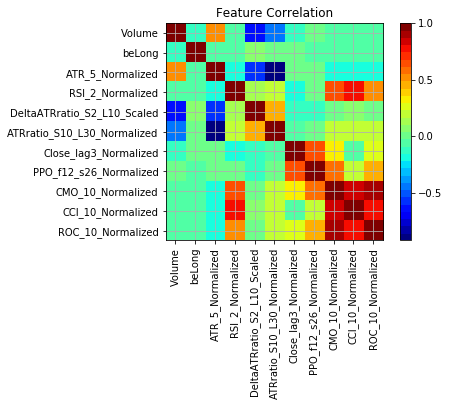

In [26]:
# Get columns to drop from feature_dict
col_vals = [k for k,v in feature_dict.items() if v == 'Drop']
# And set OHLC, etc., to Drop for cleaner correlation analysis
to_drop = ['Open','High','Low', 'gainAhead', 'Symbol', 'Date', 'Close']
for x in to_drop:
    col_vals.append(x)
mmData = dSet.drop_columns(dataSet, col_vals)

plotIt.correlation_matrix(mmData)

#### Examine and drop features with corr value > 0.85

In [27]:
# Create correlation matrix
corr_matrix = mmData.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print('Column(s) to drop: %s' % to_drop)

['ROC_10_Normalized']


In [28]:
# If there are columns to Drop, change feature dict to indicate Drop
if len(to_drop) > 0:
    for x in to_drop:
        feature_dict[x] = 'Drop'
    print(feature_dict)

{'ATR_5': 'Drop', 'ATR_5_Normalized': 'Keep', 'RSI_2': 'Drop', 'RSI_2_Normalized': 'Keep', 'DeltaATRratio_S2_L10': 'Drop', 'DeltaATRratio_S2_L10_Scaled': 'Keep', 'ATRratio_S10_L30': 'Drop', 'ATRratio_S10_L30_Normalized': 'Keep', 'Close_lag3': 'Drop', 'Close_lag3_Normalized': 'Keep', 'PPO_f12_s26': 'Drop', 'PPO_f12_s26_Normalized': 'Keep', 'CMO_10': 'Drop', 'CMO_10_Normalized': 'Keep', 'CCI_10': 'Drop', 'CCI_10_Normalized': 'Keep', 'ROC_10': 'Drop', 'ROC_10_Normalized': 'Drop'}


### Save feature_dict to json

In [30]:
save_json('feature_dict.json', feature_dict)

### (Placeholder) Examine feature importance of remaining features

### Load processing dates for IS and OOS; set start date for model analysis

In [29]:
# set date splits
isOosDates = timeUtil.is_oos_data_split(issue, pivotDate, is_oos_ratio, oos_months, segments)
dataLoadStartDate = isOosDates[0]
is_start_date = isOosDates[1]
oos_start_date = isOosDates[2]
is_months = isOosDates[3]
is_end_date = isOosDates[4]
oos_end_date = isOosDates[5]

modelStartDate = is_start_date
modelEndDate = modelStartDate + relativedelta(months=is_months)
print("Issue: " + issue)
print("IS Start date: " + str(modelStartDate) + "  IS End date: " + str(modelEndDate))

                    Segments:  2
                IS OOS Ratio:  3
                  OOS months:  4
                   IS Months:  12
              Months to load:  28
              Data Load Date:  2016-07-02
              IS Start  Date:  2016-08-02
              OOS Start Date:  2017-08-02
                  Pivot Date:  2018-04-02
Issue: TLT
IS Start date: 2016-08-02  IS End date: 2017-08-02


#### Prep data sets for classification

In [32]:
model_results = []
mmData = dataSet.loc[modelStartDate:modelEndDate].copy()
# EV related
evData = dataSet.loc[modelStartDate:modelEndDate].copy()

col_vals = [k for k,v in feature_dict.items() if v == 'Drop']
to_drop = ['Open','High','Low', 'gainAhead', 'Symbol', 'Date', 'Close']
for x in to_drop:
    col_vals.append(x)
mmData = dSet.drop_columns(mmData, col_vals)
nrows = mmData.shape[0]

In [33]:
mmData

,Volume,beLong,ATR_5_Normalized,RSI_2_Normalized,DeltaATRratio_S2_L10_Scaled,ATRratio_S10_L30_Normalized,Close_lag3_Normalized,PPO_f12_s26_Normalized,CMO_10_Normalized,CCI_10_Normalized
2016-08-02,10051207,1,0.691147,0.179089,0.604540,0.398017,0.755762,0.075076,0.224077,0.216045
2016-08-03,4930593,1,0.586599,0.222015,0.789725,0.460118,0.801322,0.092431,0.231328,0.213369
2016-08-04,5645951,-1,0.612027,0.513696,0.734103,0.456957,0.707655,0.105268,0.336373,0.391955
2016-08-05,7778635,1,0.615324,0.248952,0.729552,0.468396,0.561014,0.118087,0.211390,0.182807
2016-08-08,5185234,1,0.537933,0.326083,0.791854,0.505573,0.508979,0.126161,0.235189,0.170390
2016-08-09,5503166,1,0.502452,0.586449,0.780587,0.512015,0.576142,0.138669,0.368306,0.353004
2016-08-10,5843487,-1,0.440653,0.625339,0.839653,0.560791,0.474842,0.164082,0.419900,0.475409
2016-08-11,7624622,1,0.468774,0.286758,0.771543,0.545813,0.492640,0.186954,0.283123,0.349884
2016-08-12,7989640,-1,0.544791,0.520253,0.688578,0.496299,0.594968,0.201506,0.397957,0.602857
2016-08-15,5108563,-1,0.511379,0.283620,0.751155,0.522085,0.646540,0.209908,0.281755,0.361843


### Prepare for classification

In [35]:
######################
# ML section
######################
#  Make 'iterations' index vectors for the train-test split
iterations = 100
tscv = TimeSeriesSplit(n_splits=10)

dX, dy = modelUtil.prepare_for_classification(mmData)        

sss = StratifiedShuffleSplit(n_splits=iterations,
                             test_size=0.33,
                             random_state=None
                             )

tscv = TimeSeriesSplit(n_splits=6, max_train_size=24)

model_results = []

### Make predictions with models

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score='TRUE', random_state=55, verbose=0, warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=False,
  tol=0.001, verbose=False)
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
         

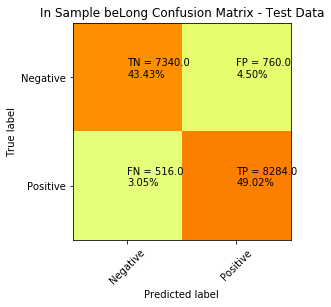

                    Accuracy:  0.92
             Precision (PPV):  0.92
     Rate of Missing Chances:  0.06
             Rate of Failure:  0.08
        Neg Pred Value (NPV):  0.93
                         MCC:  0.85
              Expected Value:  0.213%


----------------------
==Out of Sample==


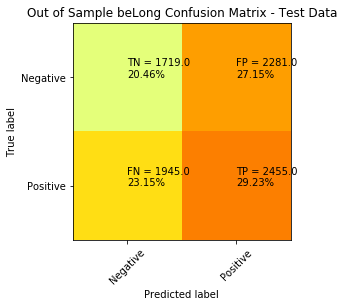

                    Accuracy:  0.50
             Precision (PPV):  0.52
     Rate of Missing Chances:  0.44
             Rate of Failure:  0.48
        Neg Pred Value (NPV):  0.47
                         MCC:  -0.01
              Expected Value:  -0.021%


KNN
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
----------------------
==In Sample==


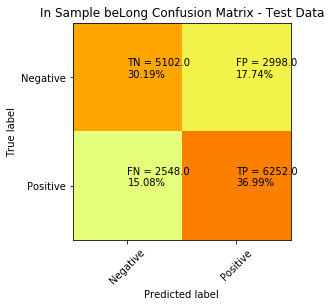

                    Accuracy:  0.67
             Precision (PPV):  0.68
     Rate of Missing Chances:  0.29
             Rate of Failure:  0.32
        Neg Pred Value (NPV):  0.67
                         MCC:  0.34
              Expected Value:  0.074%


----------------------
==Out of Sample==


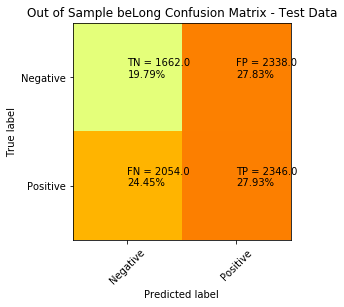

                    Accuracy:  0.48
             Precision (PPV):  0.50
     Rate of Missing Chances:  0.47
             Rate of Failure:  0.50
        Neg Pred Value (NPV):  0.45
                         MCC:  -0.05
              Expected Value:  -0.032%


SVM
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=False,
  tol=0.001, verbose=False)
----------------------
==In Sample==


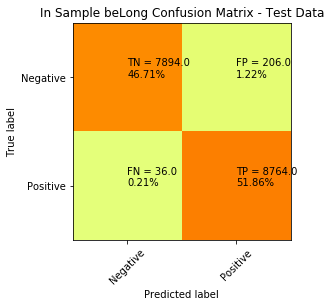

                    Accuracy:  0.99
             Precision (PPV):  0.98
     Rate of Missing Chances:  0.00
             Rate of Failure:  0.02
        Neg Pred Value (NPV):  1.00
                         MCC:  0.97
              Expected Value:  0.247%


----------------------
==Out of Sample==


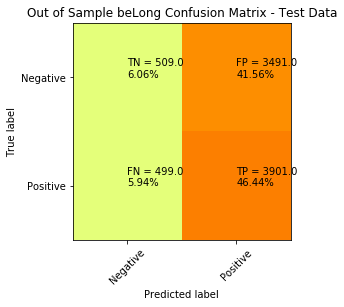

                    Accuracy:  0.53
             Precision (PPV):  0.53
     Rate of Missing Chances:  0.11
             Rate of Failure:  0.47
        Neg Pred Value (NPV):  0.50
                         MCC:  0.02
              Expected Value:  -0.024%


AdaBoost
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.2, n_estimators=500, random_state=None)
----------------------
==In Sample==


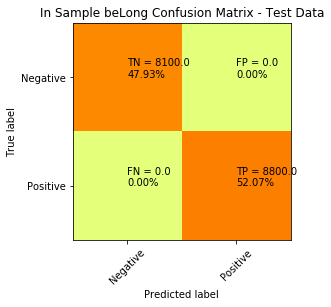

                    Accuracy:  1.00
             Precision (PPV):  1.00
     Rate of Missing Chances:  0.00
             Rate of Failure:  0.00
        Neg Pred Value (NPV):  1.00
                         MCC:  1.00
              Expected Value:  0.255%


----------------------
==Out of Sample==


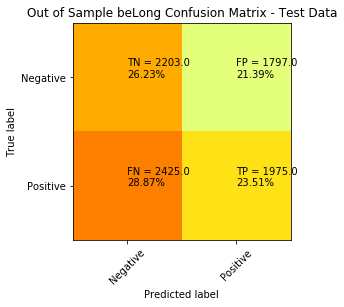

                    Accuracy:  0.50
             Precision (PPV):  0.52
     Rate of Missing Chances:  0.55
             Rate of Failure:  0.48
        Neg Pred Value (NPV):  0.48
                         MCC:  -0.00
              Expected Value:  -0.014%


GTB
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
----------------------
==In Sample==


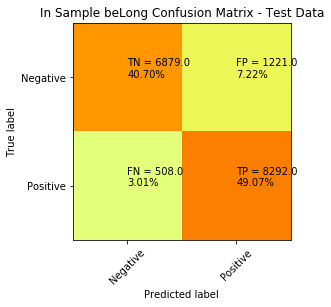

                    Accuracy:  0.90
             Precision (PPV):  0.87
     Rate of Missing Chances:  0.06
             Rate of Failure:  0.13
        Neg Pred Value (NPV):  0.93
                         MCC:  0.80
              Expected Value:  0.196%


----------------------
==Out of Sample==


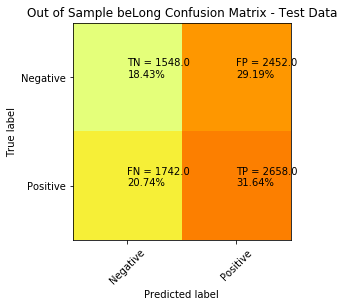

                    Accuracy:  0.50
             Precision (PPV):  0.52
     Rate of Missing Chances:  0.40
             Rate of Failure:  0.48
        Neg Pred Value (NPV):  0.47
                         MCC:  -0.01
              Expected Value:  -0.022%


QDA
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)
----------------------
==In Sample==


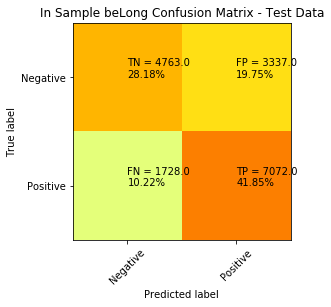

                    Accuracy:  0.70
             Precision (PPV):  0.68
     Rate of Missing Chances:  0.20
             Rate of Failure:  0.32
        Neg Pred Value (NPV):  0.73
                         MCC:  0.40
              Expected Value:  0.085%


----------------------
==Out of Sample==


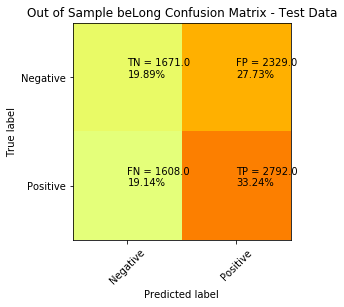

                    Accuracy:  0.53
             Precision (PPV):  0.55
     Rate of Missing Chances:  0.37
             Rate of Failure:  0.45
        Neg Pred Value (NPV):  0.51
                         MCC:  0.05
              Expected Value:  -0.005%


[{'Issue': 'TLT', 'StartDate': '2016-08-02', 'EndDate': '2017-08-02', 'Model': 'RF', 'Rows': 253, 'beLongCount': '132', 'Features': ['ATR_5_Normalized', 'RSI_2_Normalized', 'DeltaATRratio_S2_L10_Scaled', 'ATRratio_S10_L30_Normalized', 'Close_lag3_Normalized', 'PPO_f12_s26_Normalized', 'CMO_10_Normalized', 'CCI_10_Normalized'], 'IS-Accuracy': 0.92011834319526609, 'IS-Precision': 0.91277571790434253, 'IS-Recall': 0.93659090909090903, 'IS-F1': 0.92431658846040066, 'IS-EV': 0.21039882253736866, 'OOS-Accuracy': 0.48928571428571432, 'OOS-Precision': 0.51145734247223262, 'OOS-Recall': 0.54159090909090901, 'OOS-F1': 0.52404394784235064, 'OOS-EV': -0.024998635648817057}, {'Issue': 'TLT', 'StartDate': '2016-08-02', 'EndDate': '2017-08-02', 'Mo

In [44]:
to_model = {"RF": modelAlgo.setRFClass(min_samples_split=20,
                                       n_estimators=200,
                                       max_features=None
                                       ),
            "KNN": modelAlgo.setKNNClass(n_neighbors=5),
            "SVM": modelAlgo.setSVMClass(),
            "AdaBoost": modelAlgo.setAdaBoostClass(learning_rate=0.2,
                                                   n_estimators=500
                                                  ),
            "GTB": modelAlgo.setGTBClass(learning_rate=0.05,
                                         subsample=0.5,
                                         max_depth=6,
                                         n_estimators=10
                                        ),
            "QDA": modelAlgo.setQDAClass()}
for key, value in to_model.items():
    modelname = key
    model = value
    info_dict = {'issue':issue, 'modelStartDate':modelStartDate, 'modelEndDate':modelEndDate, 'modelname':modelname, 'nrows':nrows}
    print(modelname)
    print(model)

    model_results = modelUtil.model_and_test(dX, dy, model, model_results, sss, info_dict, evData)
print(model_results)

### Save results

In [45]:
## loop ended, print results
df = pd.DataFrame(model_results)
df = df[['Issue','StartDate','EndDate','Model','Rows','beLongCount','Features','IS-Accuracy','IS-Precision','IS-Recall','IS-F1','OOS-Accuracy','OOS-Precision','OOS-Recall','OOS-F1']]
print(df)

  Issue   StartDate     EndDate     Model  Rows beLongCount  \
0   TLT  2016-08-02  2017-08-02        RF   253         132   
1   TLT  2016-08-02  2017-08-02       KNN   253         132   
2   TLT  2016-08-02  2017-08-02        RF   253         132   
3   TLT  2016-08-02  2017-08-02       KNN   253         132   
4   TLT  2016-08-02  2017-08-02       SVM   253         132   
5   TLT  2016-08-02  2017-08-02  AdaBoost   253         132   
6   TLT  2016-08-02  2017-08-02       GTB   253         132   
7   TLT  2016-08-02  2017-08-02       QDA   253         132   

                                            Features  IS-Accuracy  \
0  [ATR_5_Normalized, RSI_2_Normalized, DeltaATRr...     0.920118   
1  [ATR_5_Normalized, RSI_2_Normalized, DeltaATRr...     0.674497   
2  [ATR_5_Normalized, RSI_2_Normalized, DeltaATRr...     0.924497   
3  [ATR_5_Normalized, RSI_2_Normalized, DeltaATRr...     0.671834   
4  [ATR_5_Normalized, RSI_2_Normalized, DeltaATRr...     0.985680   
5  [ATR_5_Normaliz

In [46]:
## Save results
dirext = system_name + '_start_' + str(dataLoadStartDate) + '_end_' + str(pivotDate) + '_' + datetime.datetime.now().strftime("%Y-%m-%d")
print(dirext)
filename = dirext + "IS_model_iteration.csv"
df.to_csv(system_directory+ "\\" + filename, encoding='utf-8', index=False)

TLT-Long-system-7973-V1_start_2016-07-02_end_2018-04-02_2019-01-31
